# CPSC 330 hw4

Meta-commentary: this assignment contains more new material that I created specifically for CPSC 330, whereas previous assignments relied more on adapting materials from other courses. As a result, in this assignment it is more likely that we will encounter typos, bugs, or other frustrations. Please be patient as we work through these issues.

Following the style of the lectures, this assignment is centred around a particular dataset and is also somewhat more open-ended than the previous ones. This reflects the direction that I'm trying to take the course, namely to give you practice with, and build good habits for, the end-to-end ML process. However, if this turns out to be too messy or too difficult to grade then I may revert back to less open-ended assignments in the future. Note that, given this style, there are many possible correct answers - you should not expect exactly the same results as your classmates.

It is also a bit hard for me to gauge the right length and difficulty for a new assignment, so please do provide feedback in your repo's README!

In [265]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import datasets
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, roc_curve, roc_auc_score

from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split

In [266]:
plt.rcParams['font.size'] = 14

In [267]:
def model_metrics(model, X, y):
    predictions = model.predict(X)
    TN, FP, FN, TP = confusion_matrix(y, predictions).ravel()
    print(confusion_matrix(y, predictions))

    # Calculate evaluation metrics 
    accuracy = (TP+TN)/(TN+FP+FN+TP)
    error = (FP+FN)/(TN+FP+FN+TP)
    precision = TP/(TP + FP)
    recall = TP/(TP + FN)
    f1 = 2* (precision * recall)/(precision + recall)
    data = {}
    data['accuracy'] = [accuracy]
    data['error'] = [error]
    data['precision'] = [precision]
    data['recall'] = [recall]
    data['f1'] = [f1]

    metrics_df = pd.DataFrame(data)
    return metrics_df

## Instructions
rubric={points:5}

Follow the [homework submission instructions](https://github.students.cs.ubc.ca/cpsc330-2019w-t2/home/blob/master/docs/homework_instructions.md). 

**Additional requirement**: if you are working with a partner, please write a couple sentences explaining the contribution of each team member. You should refer to yourselves by your CSIDs (because seeing names can cause bias during grading). Here is an example:

> a1b2c did Exercise 1, checked over Exercise 2, and pair-programmed for Exercise 3. z9y8x checked over Exercise 1, did Exercise 2, and pair-programmed for Exercise 3. 

Our ideal scenario is that you worked together on all the exercises, but you are not required to do so, and for now we are only collecting this information because we are curious. If you are working alone, you can ignore this section.

Both of us (b9h0b and x8p1b) attempted the entire assignment and corss checked our answers

## Writing quality/quantity
rubric={points:5}

The TAs have reported a couple issues with the first few assignments: in some cases, submissions simply show the code output with no commentary; please write at least a sentence explaining your output in each question. In other cases, the TAs have come across multi-paragraph answers where a couple of sentences would have sufficed. Thus, we are now allocating the above points for well-structured answers of a reasonable length. In general, 1-3 sentences is good.

## Exercise 1: implementing `DummyClassifier`
rubric={points:20}

In this course (unlike CPSC 340) you will generally not be asked to implement the methods we talk about, like logistic regression. However, this exercise is an exception: you will implement the simplest possible classifier, `DummyClassifier`.

Below you will find starter code for a class called `MyDummyClassifier`, which has methods `fit()`, `predict()`, and `predict_proba()`. Your task is to fill in those three functions. The next code block has some tests you can use to assess whether your code is working. 

I suggest starting with `fit` and `predict`, and making sure those are working before moving on to `predict_proba`. For `predict_proba`, you should return the frequency of each class in the training data. Again, you can compare with `DummyClassifier` using the code below.

To simplify this question, you can assume **binary classification**, and furthermore that these classes are **encoded as 0 and 1**. In other words, you can assume that `y` contains only 0s and 1s. The real `DummyClassifier` works when you have more than two classes, and also works if the target values are encoded differently, for example as "cat", "dog", "mouse", etc.

In [358]:
class MyDummyClassifier:
    """
    A baseline classifier that predicts the most common class.
    The predicted probabilities come from the relative frequencies
    of the classes in the training data.
    
    This implementation only works when y only contains 0s and 1s.
    """
    def fit(self, X, y):
        target_labels = pd.Series(y)
        self.mostCommonLabel = target_labels.value_counts().idxmax()
        self.probs = np.array([y.size - np.count_nonzero(y), np.count_nonzero(y)])/y.size
        return self                
        
    def predict(self, X):
        return np.full(X.shape[0], self.mostCommonLabel)    
        
    
    def predict_proba(self, X):
        return np.tile(self.probs, (X.shape[0], 1))
        

Below are some tests for `predict`. You may want to run the cell a few times to make sure you explore the different cases (or automate this with a loop or random seeds).

In [359]:
# For testing, generate random data
n_train = 101
n_valid = 21
d = 5
X_train_dummy = np.random.randn(n_train, d)
X_valid_dummy = np.random.randn(n_valid, d)
y_train_dummy = np.random.randint(2, size=n_train)
y_valid_dummy = np.random.randint(2, size=n_valid)

my_dc = MyDummyClassifier()
sk_dc = DummyClassifier(strategy="prior")

my_dc.fit(X_train_dummy, y_train_dummy);
sk_dc.fit(X_train_dummy, y_train_dummy);

assert np.array_equal(my_dc.predict(X_train_dummy), sk_dc.predict(X_train_dummy))
assert np.array_equal(my_dc.predict(X_valid_dummy), sk_dc.predict(X_valid_dummy))


Below are some tests for `predict_proba`.

In [360]:
print(sk_dc.predict_proba(X_train_dummy)[0])
print(my_dc.predict_proba(X_train_dummy)[0])
assert np.allclose(my_dc.predict_proba(X_train_dummy), sk_dc.predict_proba(X_train_dummy))
assert np.allclose(my_dc.predict_proba(X_valid_dummy), sk_dc.predict_proba(X_valid_dummy))

[0.65346535 0.34653465]
[0.65346535 0.34653465]


## Exercise 2: Precision and recall by hand

Below is the confusion matrix of a machine learning system that predicts whether a cancer is malignant or not. Let's consider malignant to be the "positive class".

|    Actual/Predicted      | Predicted Benign | Predicted Malignant |
| :------------- | -----------------------: | -----------------------: |
| **Actual Benign**       | 6 | 238 |
| **Actual Malignant**       | 20 | 194 |

#### 2(a)
rubric={points:2}

Would you consider this an imbalanced dataset? Why or why not? Max 2 sentences.

    

No, it's not. There is roughly an equal split between benign and malignant examples (244 benign / 214 malignant)

#### 2(b)
rubric={points:2}

Based on the above confusion matrix, what is the recall? 

    

$\text{Recall} = \dfrac{194}{194 + 20} = 0.906$

#### 2(c)
rubric={points:5}

Do you consider this to be a good classifier? What additional information might you need to answer this question? Briefly discuss in 1-3 sentences.

    

It depends. From an accuracy perspective, we're getting $\dfrac{194+6}{194+6+20+238} = 43.6\%$ which is not good. Precision is $\dfrac{194}{194+238} = 0.449$, which is also not good. However the classifier has a high recall rate, which means it will try to classify most examples as "Malignant". If we know it is more important to classify malignant cases, then this model is good enough for the task

## Exercise 3: Customer churn data

[Customer churn](https://en.wikipedia.org/wiki/Customer_attrition) refers to the notion of customers leaving a subscription service like Netflix. In this exercise, we will try to predict customer churn in a dataset where most of the customers stay with the service and a small minority cancel their subscription. To start, please download the [Kaggle telecom customer churn dataset](https://www.kaggle.com/becksddf/churn-in-telecoms-dataset). **Do not push the CSV to your repo** (you may want to create a .gitignore file). One you have the data, you should be able to run the following code:

In [271]:
df = pd.read_csv('bigml_59c28831336c6604c800002a.csv', encoding='latin-1')

In [272]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=100)
df_train, df_valid = train_test_split(df_train, test_size=0.25, random_state=100)

In [273]:
df_train.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
706,CO,108,415,400-5984,no,no,0,215.6,78,36.65,...,119,16.60,194.4,65,8.75,3.6,5,0.97,1,False
3204,ID,105,408,363-3469,no,no,0,232.6,96,39.54,...,117,21.54,154.0,101,6.93,10.5,9,2.84,1,False
1770,OH,106,415,364-4927,no,no,0,158.6,112,26.96,...,114,18.70,252.9,106,11.38,9.1,3,2.46,0,False
3254,IL,57,415,403-6237,no,yes,30,179.2,105,30.46,...,83,24.07,228.1,77,10.26,14.7,5,3.97,1,False
2197,LA,133,415,360-7079,no,no,0,216.2,67,36.75,...,133,18.89,192.0,95,8.64,3.1,1,0.84,2,False


The last column (`churn`) is the target. "True" means the customer left the subscription (churned) and "False" means they stayed.

**Note**: in this exercise you are welcome to copy/paste/adapt code from the **lecture notes** without attribution. However, you are **not** permitted to copy any other code from online sources without attribution.

**Note**: if available, you are welcome to use scikit-learn functions for any of the tasks below, such as confusion matrix. You are not required to implement them yourselves. 

#### 3(a)  
rubric={points:8} 

Perform some exploratory data analysis on the training set. In particular:

- How many rows and columns are there?
- How many True/False target values are there?

Come up with **two** more questions you would like to answer (similar to the above two), and explore those as well. Briefly discuss your results in 1-3 sentences.

In [212]:
df_train.shape

(2249, 21)

In [213]:
df_train["churn"].value_counts()

False    1917
True      332
Name: churn, dtype: int64

In [214]:
df_train.describe()

,account length,area code,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
count,2249.000000,2249.000000,2249.000000,2249.000000,2249.000000,2249.000000,2249.000000,2249.000000,2249.000000,2249.000000,2249.000000,2249.000000,2249.000000,2249.000000,2249.000000,2249.000000
mean,101.029346,437.572254,7.890618,179.182259,99.921743,30.461547,201.171676,100.203646,17.099831,202.469453,100.244108,9.111232,10.255225,4.436639,2.769413,1.576701
std,39.941851,42.603258,13.580967,54.724285,20.045081,9.303134,50.375700,19.868593,4.281931,50.522384,19.431706,2.273568,2.827567,2.439045,0.763389,1.332094
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,42.500000,12.000000,3.610000,43.700000,33.000000,1.970000,0.000000,0.000000,0.000000,0.000000
25%,73.000000,408.000000,0.000000,143.500000,87.000000,24.400000,167.200000,87.000000,14.210000,168.500000,87.000000,7.580000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.100000,100.000000,30.450000,201.300000,100.000000,17.110000,202.400000,100.000000,9.110000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,18.000000,215.600000,114.000000,36.650000,235.200000,114.000000,19.990000,237.300000,114.000000,10.680000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,166.000000,17.770000,20.000000,20.000000,5.400000,9.000000


In [215]:
df_train["international plan"].value_counts()

no     2028
yes     221
Name: international plan, dtype: int64

The training dataset has 2249 examples, 1917 of them are customers who stayed (labelled as false). The number of calls made at night is roughly the same as those made during the day, 100.24 as opposed to 99.92. Most customers did not have an international plan, that is 2028 customers.

#### 3(b)
rubric={points:20}

In preparation for building a classifier, perform whatever feature transformations you deem sensible. Use `ColumnTransformer` to combine the transformations (see Lecture 6 or 8). This can include dropping features if you think they are not helpful. 

In each case, briefly explain your rationale with 1-2 sentences. You do not need an explanation for every feature, but for every group of features that are being transformed the same way. For example, "I am doing transformation X to the following categorical features: `a`, `b`, `c` because of reason Y," etc.

Warning: as discussed in lecture, make sure not to violate the golden rule; you should not be calling `fit` or `fit_transform` on any test data!

In [216]:
X_train = df_train.drop(columns='churn')
X_valid = df_valid.drop(columns='churn')
y_train = df_train['churn']
y_valid = df_valid['churn']

In [217]:
numeric_features = ['account length', 'number vmail messages', 
                    'total day minutes', 'total day calls', 'total day charge',
                    'total eve minutes', 'total eve calls', 'total eve charge',
                    'total night minutes', 'total night calls', 'total night charge', 
                    'total intl minutes', 'total intl calls', 'total intl charge', 'customer service calls']

categorical_features = ['state', 'voice mail plan', 'international plan']

In [218]:
# Create the feature transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('scale', StandardScaler(), numeric_features),
        ('ohe', OneHotEncoder(drop="first", sparse=False), categorical_features)])

# Fit on training data
preprocessor.fit(X_train);

# Get list of transformed columns
columns = numeric_features + list(preprocessor.named_transformers_['ohe']
                                     .get_feature_names(categorical_features))
# transform training and validation datasets
X_train_transformed = pd.DataFrame(preprocessor.transform(X_train), index=X_train.index, columns=columns)
X_valid_transformed = pd.DataFrame(preprocessor.transform(X_valid), index=X_valid.index, columns=columns)

First, got rid of features that are not useful for training such as `phone number` and `area code`. The next step was to transform categorical features to numerical ones using `one hot encoding`. And lastly, standardized numerical features using `standard scaler` to center them around around zero

#### 3(c)
rubric={points:10}

"Train" a `DummyClassifier` on your transformed data, using `strategy='prior'` as in Exercise 1. Report the following:

1. Train and validation accuracy.
2. Confusion matrix on the validation data.
3. Precision, recall, F1-score on the validation data.

Briefly comment on your results (2 sentences max).

In [219]:
# dummy classifier to establish base accuracy
dc = DummyClassifier(strategy="prior")
dc.fit(X_train_transformed, y_train);

print("Training accuracy: %.3f" % (dc.score(X_train_transformed, y_train)))
print("Validation accuracy: %.3f" % (dc.score(X_valid_transformed, y_valid)))

Training accuracy: 0.852
Validation accuracy: 0.848


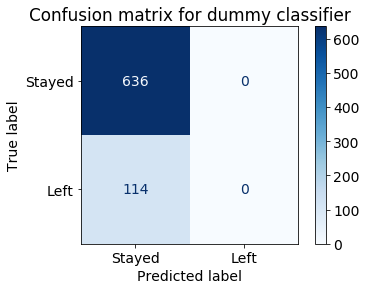

In [220]:
# plot confusion matrix
disp = plot_confusion_matrix(dc, X_valid, y_valid,
                             display_labels=['Stayed', 'Left'],
                             cmap=plt.cm.Blues, 
                             values_format = 'd')
disp.ax_.set_title('Confusion matrix for dummy classifier');

In [221]:
# Dummy classifier metrics
model_metrics(dc, X_valid_transformed, y_valid)

[[636   0]
 [114   0]]


C:\Users\Ahmed\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in longlong_scalars
  if __name__ == '__main__':


,accuracy,error,precision,recall,f1
0,0.848,0.152,NaN,0.0,NaN


The base classifier has validation accuracy of $84.4\%$, obtained by predicting the most common class label for customers which is `Stayed`

#### 3(d)
rubric={points:20} 

Train a logistic regression classifier on your transformed data, using the default hyperparameters. Report the following metrics:

1. Train and validation accuracy.
2. Confusion matrix on the validation data.
3. Precision, recall, F1-score on the validation data.

Are you satisfied with the results? Use your `DummyClassifier` results as a reference point. Briefly discuss (1 paragraph max). 

In [222]:
# logistic regression model
lr = LogisticRegression()
lr.fit(X_train_transformed, y_train);

print("Training accuracy: %.3f" % (lr.score(X_train_transformed, y_train)))
print("Validation accuracy: %.3f" % (lr.score(X_valid_transformed, y_valid)))

Training accuracy: 0.871
Validation accuracy: 0.861


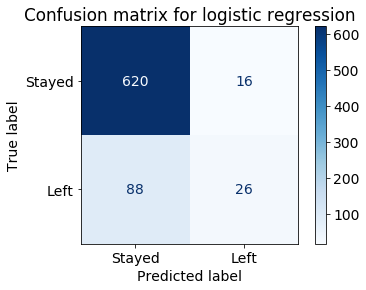

In [223]:
# plot confusion matrix
disp = plot_confusion_matrix(lr, X_valid_transformed, y_valid,
                             display_labels=['Stayed', 'Left'],
                             cmap=plt.cm.Blues, 
                             values_format = 'd')
disp.ax_.set_title('Confusion matrix for logistic regression');

In [224]:
# Logistic regression classifier metrics
model_metrics(lr, X_valid_transformed, y_valid)

[[620  16]
 [ 88  26]]


,accuracy,error,precision,recall,f1
0,0.861333,0.138667,0.619048,0.22807,0.333333


Compared to the dummy classifier, the logistic regression model has a better validation accuracy of $86.1\%$. It has better precision of $0.62$ and recall of $0.228$. All of these are an improvement over the base classifier

#### 3(e)
rubric={points:5}

Set the `class_weight` parameter of your logistic regression model to `'balanced'`. Report the following metrics:

1. Train and validation accuracy.
2. Confusion matrix on the validation data.
3. Precision, recall, F1-score on the validation data.

Discuss your results in 1-3 sentences.

In [225]:
# Logsitic regression model, with balanced class weights 
blr = LogisticRegression(class_weight='balanced')
blr.fit(X_train_transformed, y_train);

print("Training accuracy: %.3f" % (blr.score(X_train_transformed, y_train)))
print("Validation accuracy: %.3f" % (blr.score(X_valid_transformed, y_valid)))

Training accuracy: 0.779
Validation accuracy: 0.749


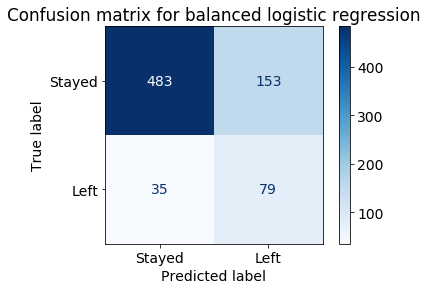

In [226]:
# plot confusion matrix
disp = plot_confusion_matrix(blr, X_valid_transformed, y_valid,
                             display_labels=['Stayed', 'Left'],
                             cmap=plt.cm.Blues, 
                             values_format = 'd')
disp.ax_.set_title('Confusion matrix for balanced logistic regression');

In [227]:
# Logistic regression classifier metrics
model_metrics(blr, X_valid_transformed, y_valid)

[[483 153]
 [ 35  79]]


,accuracy,error,precision,recall,f1
0,0.749333,0.250667,0.340517,0.692982,0.456647


Validation accuracy of the logistic regressor with balanced class weights is $74.9\%$ which is below that of the vanilla logistic classifier. However, it has better recall of $0.692$ due to the increased number of true positive predictions (customers who indeed left)

#### 3(f)
rubric={points:5}

On the same axes, plot the ROC curves for the three methods we tried. Make sure you have a legend labeling which curve is which. Also, report the AUC in each case. Briefly comment on your results (1 sentence).


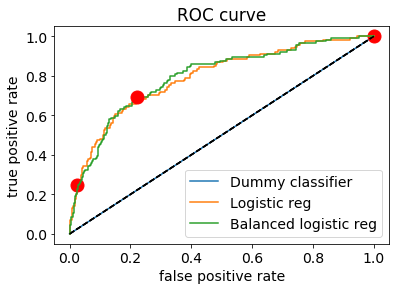

In [228]:
models = [dc, lr, blr]
model_names = ['Dummy classifier', 'Logistic reg', 'Balanced logistic reg']
for i, model in enumerate(models):
    fpr, tpr, thresholds = roc_curve(y_valid, model.predict_proba(X_valid_transformed)[:,1])
    plt.plot(fpr, tpr, label=model_names[i]);
    plt.plot((0,1),(0,1),'--k');
    ind = np.argmin(np.abs(thresholds-0.5))
    plt.plot(fpr[ind], tpr[ind], 'ro', markersize=13)
    plt.xlabel('false positive rate');
    plt.ylabel('true positive rate');
    plt.title("ROC curve");
    plt.legend();

In [229]:
# Logistic regression AUC
roc_auc_score(y_valid, lr.predict_proba(X_valid_transformed)[:,1])

0.791087388282026

In [230]:
# Balanced logistic regression AUC
roc_auc_score(y_valid, blr.predict_proba(X_valid_transformed)[:,1])

0.7946182279598367

In [231]:
# Dummy classifier AUC
roc_auc_score(y_valid, dc.predict(X_valid_transformed))

0.5

Both logistic and balanced logistic regressors perform better than the dummy classifier, with AUC = 0.79 that is close to the perfect classifier (AUC = 1)

#### 3(g)
rubric={points:10}

The function below plots histograms of the predicted probability, split by the true class, for each of the two logistic regression models. These are similar to the animated plots from lecture. 

Call this function using your (transformed) **validation** data and your two logistic regression models. Then, discuss your results. How did the regular and balanced logistic regression models compare in terms of accuracy and recall? How did the two models compare in terms of ROC curves? Do these new plots help explain what is going on here? Max 1 paragraph.

In [232]:
def make_hists(X, y, lr_original, lr_balanced):

    negative_examples = X[y == 0]
    positive_examples = X[y == 1]

    for name, model in {"log reg" : lr, "log reg balanced" :lr_balanced}.items():

        plt.hist(model.predict_proba(negative_examples)[:,1], alpha=0.5, bins=30, label="0", density=True)
        plt.hist(model.predict_proba(positive_examples)[:,1], alpha=0.5, bins=30, label="1", density=True)
        plt.legend(loc='upper right')

        plt.xlabel("predicted probability")
        plt.ylabel("normalized counts")
        plt.title(name);
        plt.show()
    

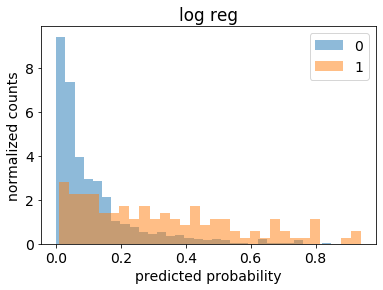

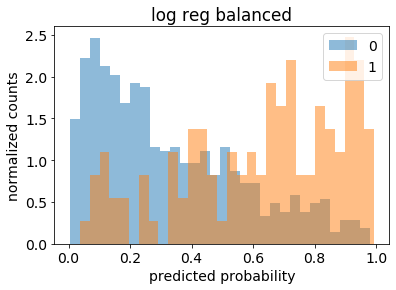

In [233]:
make_hists(X_valid_transformed, y_valid, lr, blr)

In terms of validation accuracy, the original logistic regression model performs better than the one with balanced class weights, $86.1$ as opposed to $79.4$. But it has lower recall of $0.228$ as opposed to $0.692$, which means it was less able to identify true positive examples. The ROC curves for both models were quite similar

## Exercise 4: Hyperparameter optimization

#### 4(a)
rubric={points:5}

Try applying a random forest to this problem, again using `class_weight='balanced'`. Report the following metrics:

1. Train and validation accuracy.
2. Confusion matrix on the validation data.
3. Precision, recall, F1-score on the validation data. 

Briefly comment on the results (max 2 sentences).

In [234]:
# Random forest classifier with balanced class weights 
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_train_transformed, y_train);

print("Training accuracy: %.3f" % (rf.score(X_train_transformed, y_train)))
print("Validation accuracy: %.3f" % (rf.score(X_valid_transformed, y_valid)))

Training accuracy: 1.000
Validation accuracy: 0.924


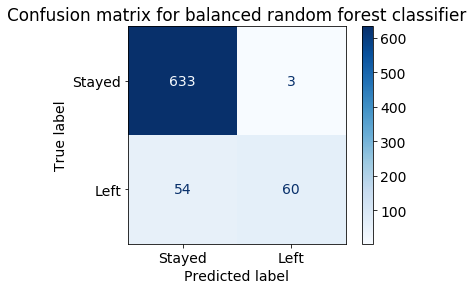

In [235]:
# plot confusion matrix
disp = plot_confusion_matrix(rf, X_valid_transformed, y_valid,
                             display_labels=['Stayed', 'Left'],
                             cmap=plt.cm.Blues, 
                             values_format = 'd')
disp.ax_.set_title('Confusion matrix for balanced random forest classifier');

In [236]:
# Random forest classifier metrics
model_metrics(rf, X_valid_transformed, y_valid)

[[633   3]
 [ 54  60]]


,accuracy,error,precision,recall,f1
0,0.924,0.076,0.952381,0.526316,0.677966


The random forest classifier has the best validation accuracy of $91.6\%$. A very high precision of 0.981 indicates that almost all of the postive predictions it made were correct 

#### 4(b)
rubric={points:5}

Next we will optimize the `n_estimators` hyperparameter of your random forest using `RandomizedSearchCV`, keeping `class_weight='balanced'`. Because cross-validation separates the folds for us, I will combine the training and validation sets so that we have more data to work with. 

In [237]:
X_train_valid = np.concatenate((X_train_transformed, X_valid_transformed), axis=0)
y_train_valid = np.concatenate((y_train, y_valid), axis=0)

In [238]:
import scipy.stats

param_dist = {
              "n_estimators"     : scipy.stats.randint(low=10, high=300),
             }

In [239]:
random_search = RandomizedSearchCV(RandomForestClassifier(class_weight='balanced', random_state=321), 
                                   param_distributions = param_dist, 
                                   n_iter = 20, 
                                   cv=3,
                                   verbose=1, 
                                   random_state=123)

In [240]:
random_search.fit(X_train_valid, y_train_valid);

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  1.2min finished


In [241]:
random_search.best_params_

{'n_estimators': 263}

In [242]:
random_search.score(X_valid_transformed, y_valid)

1.0

This model is incredible - it gets 100% validation accuracy! This means it make no errors, so it must also be getting a perfect precision, recall, and F1-score.
What is wrong with my analysis? Answer in 1-2 sentences.

(Note: when you run the above code you might get slightly different results, depending on your feature preprocessing in Exercise 3. That is fine. Hopefully the score isn't too different.)

In [243]:
# Random search metrics
model_metrics(random_search, X_valid_transformed, y_valid)

[[636   0]
 [  0 114]]


,accuracy,error,precision,recall,f1
0,1.0,0.0,1.0,1.0,1.0


The model scores 100% on validation data because it saw it before, during the training phase. This should not be the case of how validation data should be handled

#### 4(c)
rubric={points:5}

Repeat the hyperparameter optimization from the previous part, this time doing it correctly. For your optimized model, report the F1-score on the validation set. Briefly comment on the results (max 2 sentences).

In [244]:
random_search.fit(X_train_transformed, y_train);

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   53.3s finished


In [245]:
# Random search metrics
model_metrics(random_search, X_valid_transformed, y_valid)

[[632   4]
 [ 56  58]]


,accuracy,error,precision,recall,f1
0,0.92,0.08,0.935484,0.508772,0.659091


The random search has better accuracy than random forest with no hyperparameter optimizations, 92% as opposed to 91%. It also has a better f1 score of 0.65

#### 4(d)
rubric={points:5}

This time optimize both `n_estimators` and `max_depth`. What F1-score do you get on the validation set?

In [246]:
import scipy.stats

param_dist = {
              "n_estimators"     : scipy.stats.randint(low=10, high=300),
              "max_depth"        : scipy.stats.randint(low=10, high=30),
             }

In [247]:
random_search = RandomizedSearchCV(RandomForestClassifier(class_weight='balanced', random_state=321), 
                                   param_distributions = param_dist, 
                                   n_iter = 20, 
                                   cv=3,
                                   verbose=1, 
                                   random_state=123)

In [248]:
random_search.fit(X_train_transformed, y_train);

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   52.3s finished


In [249]:
random_search.best_params_

{'max_depth': 11, 'n_estimators': 106}

In [250]:
# Random search metrics
model_metrics(random_search, X_valid_transformed, y_valid)

[[626  10]
 [ 45  69]]


,accuracy,error,precision,recall,f1
0,0.926667,0.073333,0.873418,0.605263,0.715026


Optimizing the random search for max depth and n_estimators provided more improvements in terms of accuracy and f1 score (92.6% and 0.71) compared to the previous random search step (92% and 0.65)

#### 4(e) 
rubric={points:5}

When you carry out hyperparameter optimization, by default it is maximizing accuracy. In unbalanced datasets such as churn datasets, using accuracy does not make sense. You can use different [scoring metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics) when you carry out hyperparameter optimization using `GridSearchCV` or `RandomizedSearchCV` using the `scoring` parameter. Try optimizing your model to pick the hyerparameters with the best F1-score by setting `scoring='f1'` when creating the `RandomizedSearchCV`. What F1-score do you achieve on the validation set?

Optional note / FYI: in the case of random search with a fixed random seed, you will end up exploring the same hyperparameter values as in the previous part. The only difference will be which one you consider the best. However, if you were using a fancier method like Bayesian optimization, then the choice of scoring function would actually affect which hyperparameter values were explored, because the suggested next set of hyperparameters depends on the scores of the previous ones.

In [251]:
import scipy.stats

param_dist = {
              "n_estimators"     : scipy.stats.randint(low=10, high=300),
              "max_depth"        : scipy.stats.randint(low=10, high=30),
             }

In [252]:
random_search = RandomizedSearchCV(RandomForestClassifier(class_weight='balanced', random_state=321), 
                                   param_distributions = param_dist,
                                   scoring='f1',
                                   n_iter = 20, 
                                   cv=3,
                                   verbose=1, 
                                   random_state=123)

In [253]:
random_search.fit(X_train_transformed, y_train);

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   53.3s finished


In [254]:
random_search.best_params_

{'max_depth': 10, 'n_estimators': 234}

In [255]:
# Random search metrics
model_metrics(random_search, X_valid_transformed, y_valid)

[[624  12]
 [ 40  74]]


,accuracy,error,precision,recall,f1
0,0.930667,0.069333,0.860465,0.649123,0.74


This random search achieves the highest f1 score of 0.74

#### 4(f)
rubric={points:5}

Evaluate your final model on the test data. Briefly discuss your results (1-2 sentences).

In [258]:
# Transform test data
X_test = df_test.drop(columns='churn')
y_test = df_test['churn']
X_test_transformed = pd.DataFrame(preprocessor.transform(X_test), index=X_test.index, columns=columns)

In [264]:
# Random search metrics on test data
model_metrics(random_search, X_test_transformed, y_test)

[[291   6]
 [ 14  23]]


,accuracy,error,precision,recall,f1
0,0.94012,0.05988,0.793103,0.621622,0.69697


The random search model has very high test accuracy of 94%, in addition to high recall and precision. It does not seem to suffer from overfitting.